In [523]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import hdbscan
from scipy import stats
from sklearn import preprocessing
import matplotlib.patches as patches
from utils import read_range_data,plot_points_on_image,rgba,generate_bbox

### 1. Read Data

In [524]:
root = '/data1/yuqi_wang/waymo_lsmol'

In [525]:
segs = sorted(os.listdir(root))
print('total num:', len(segs))

total num: 5


In [854]:
seg_file = segs[4]
idx = 50

In [855]:
# path
img_root = os.path.join(root,seg_file,'image')
proposal_root = os.path.join(root,seg_file,'proposal')
sceneflow_root = os.path.join(root,seg_file,'sceneflow_extra')
range_root = os.path.join(root,seg_file,'range')
img_list = sorted(os.listdir(img_root))
proposal_list = sorted(os.listdir(proposal_root))
sceneflow_list = sorted(os.listdir(sceneflow_root))
range_list = sorted(os.listdir(range_root))
img_path = os.path.join(img_root,img_list[idx])
proposal_path = os.path.join(proposal_root,proposal_list[idx])
sceneflow_path = os.path.join(sceneflow_root,sceneflow_list[idx])
range_path = os.path.join(range_root,range_list[idx])
print(img_path)
print(proposal_path)
print(sceneflow_path)
print(range_path)
img = Image.open(img_path)
proposal = np.load(proposal_path)
sceneflow = np.load(sceneflow_path)
camera_projections = np.load(range_path)['camera_projections']

/data1/yuqi_wang/waymo_lsmol/segment-10072140764565668044_4060_000_4080_000_with_camera_labels/image/frame_000050.jpg
/data1/yuqi_wang/waymo_lsmol/segment-10072140764565668044_4060_000_4080_000_with_camera_labels/proposal/frame_000050.npy
/data1/yuqi_wang/waymo_lsmol/segment-10072140764565668044_4060_000_4080_000_with_camera_labels/sceneflow_extra/frame_000050.npy
/data1/yuqi_wang/waymo_lsmol/segment-10072140764565668044_4060_000_4080_000_with_camera_labels/range/frame_000050.npz


### 2. Visualize Initial Proposals

In [856]:
low, high= 10,5000

In [857]:
front_mask = np.where((camera_projections[:,:,0]==1)|(camera_projections[:,:,3]==1),1,0)
instance_mask = np.where(front_mask[:,:]==1,1,0)
front_proposals = list(proposal[instance_mask==1])
front_proposals_set = sorted(set(front_proposals))[1:]
print('after project to front:',len(front_proposals_set))
filter_proposal = []
for i in front_proposals_set:
    if front_proposals.count(i)>low and front_proposals.count(i)<high:
            filter_proposal.append(i)
print('after filter points:',len(filter_proposal))
pre_color = {}
colors = []
mask = np.zeros((64,2650,3))
for c in filter_proposal:
    rand_color = np.random.randint(1, 255, 3)
    pre_color[c]=rand_color
instance_mask = np.zeros((64,2650))
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if proposal[i,j] in filter_proposal:
            mask[i,j,:]=pre_color[proposal[i,j]]
            instance_mask[i,j] = proposal[i,j]
point=[]
for ins_id in filter_proposal:
    instance_prop = np.where((front_mask[:,:]==1)&(instance_mask==ins_id),1,0)
    cam = camera_projections[instance_prop==1]
    for p in range(cam.shape[0]):
        if cam[p][0]==1:
            point.append([cam[p][1],cam[p][2],ins_id])
        elif cam[p][3]==1:
            point.append([cam[p][4],cam[p][5],ins_id])

after project to front: 110
after filter points: 33


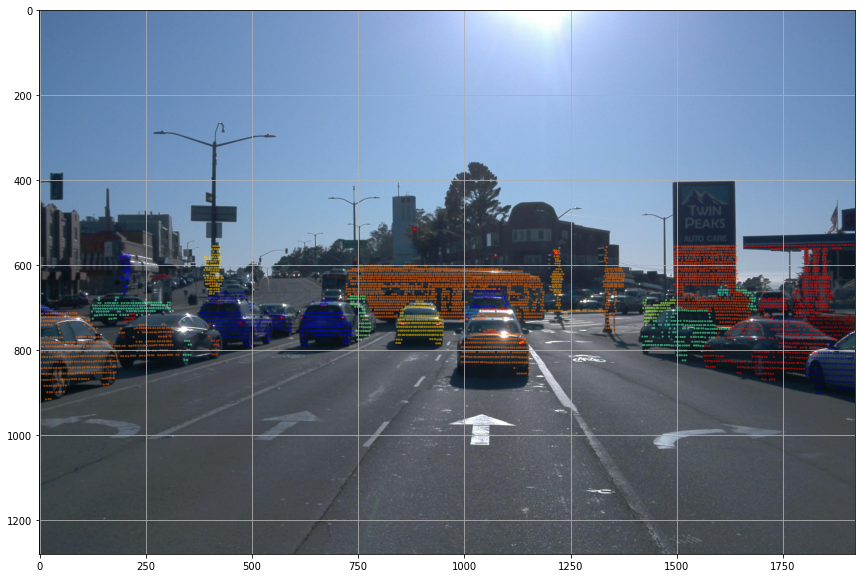

In [858]:
plot_points_on_image(point,img, rgba)

### 3. Visualize Sceneflow

In [859]:
sceneflow.shape

(4030, 9)

In [860]:
new_point = []
for i in range(sceneflow.shape[0]):
    new_point.append([sceneflow[i][0],sceneflow[i][1],sceneflow[i][2]])

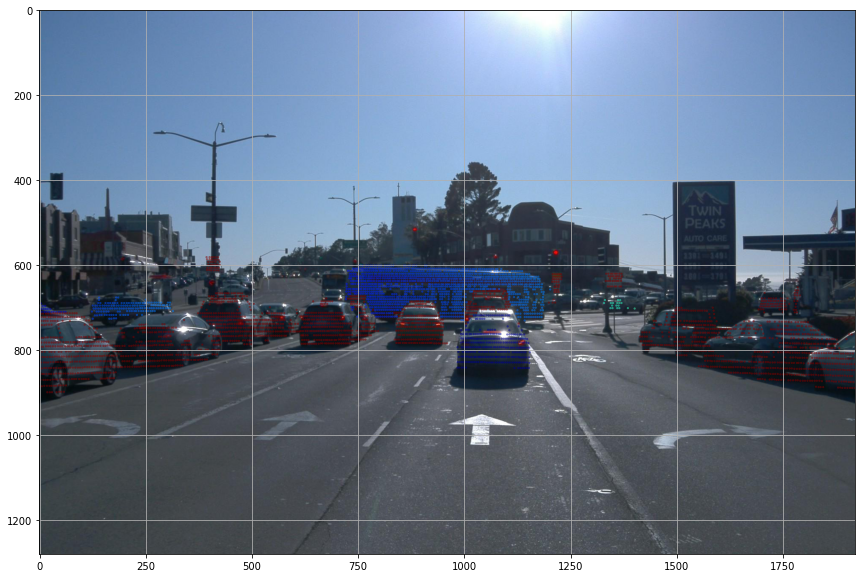

In [861]:
plot_points_on_image(new_point,img, rgba)

### 4. Visualize Movable Proposals 

In [862]:
v_t = 0.8

In [869]:
motion_count = {}
sceneflow_dict = {}

X = sceneflow[:,2:-1]
X_scaled = preprocessing.scale(X)
db = hdbscan.HDBSCAN(min_cluster_size=15,gen_min_span_tree=True).fit(X_scaled)
labels = db.labels_
movable_point = []
for i in range(sceneflow.shape[0]):
    movable_point.append([sceneflow[i][0],sceneflow[i][1],labels[i]])
for sf in range(len(movable_point)):
    pos = (int(movable_point[sf][0]),int(movable_point[sf][1]))
    v = movable_point[sf][2]
    sceneflow_dict[pos] = v
ins_index = {}
for ins_i in filter_proposal:
    v_label = []
    ins0 = [p for p in point if p[2]==ins_i]
    loc0 = [(p[0],p[1]) for p in point if p[2]==ins_i]
    count = 0
    for i in range(len(loc0)):
        if loc0[i] in sceneflow_dict.keys():
            count+=1
            v_label.append(sceneflow_dict[loc0[i]])
    rotio = count/len(loc0)
    motion_count[ins_i]=rotio
    if len(v_label)>0:
        most = stats.mode(v_label)[0][0]
        ins_index[ins_i]=most
select_id = []
for key,values in motion_count.items():
    if values>v_t:
        select_id.append(key)
print('after filter motion:',len(select_id))
final_point = []
new_id = []
for s_id in select_id:
    new  = ins_index[s_id]+max(select_id)
    point_obj = [[p[0],p[1],new] for p in point if p[2]==s_id]
    final_point.extend(point_obj)
    new_id.append(new)
new_id = set(new_id)
print('after merge:',len(new_id))

after filter motion: 21
after merge: 19


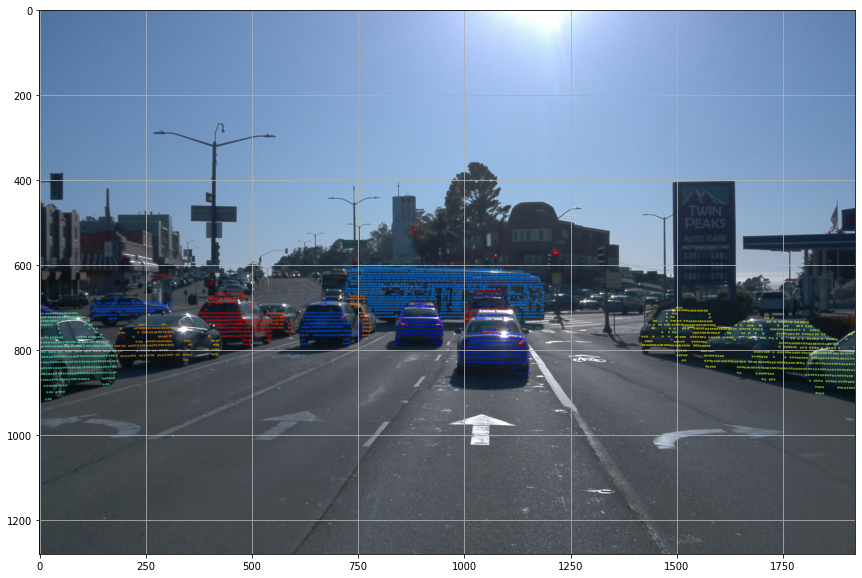

In [870]:
plot_points_on_image(final_point,img, rgba)

### 5. Visualize Box

[1039, 702, 63, 4]
[1, 688, 62, 24]
[990, 716, 166, 141]
[121, 674, 195, 54]
[719, 599, 485, 133]
[0, 711, 185, 207]
[1803, 761, 116, 143]
[1562, 722, 317, 149]
[1417, 698, 208, 128]
[389, 736, 35, 76]
[176, 727, 182, 98]
[724, 671, 56, 96]
[533, 697, 62, 61]
[371, 664, 178, 124]
[1001, 659, 83, 80]
[1018, 660, 86, 40]
[838, 683, 114, 103]
[744, 735, 16, 42]
[613, 676, 125, 111]


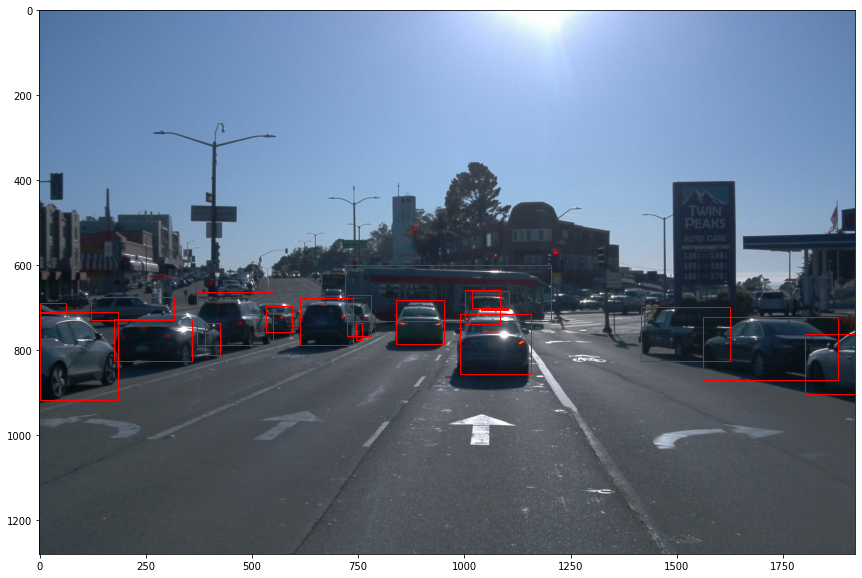

In [871]:
plt.figure(figsize=(20,10))
plt.imshow(img)
for s_id in new_id:
    point_obj = [p for p in final_point if p[2]==s_id]
    bbox = generate_bbox(np.array(point_obj))
    print(bbox)
    currentAxis=plt.gca()
    rect=patches.Rectangle(bbox[:2],bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
    currentAxis.add_patch(rect)